# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Define features

In [3]:
features = ['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 
            'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 
            'TrackDurationMs', 'Energy']
X = train[features]
y = train['BeatsPerMinute']
X_test = test[features]

# Feature engineering: Log-transform skewed features

In [4]:
X['AudioLoudness'] = np.log1p(-X['AudioLoudness'])
X_test['AudioLoudness'] = np.log1p(-X_test['AudioLoudness'])
X['TrackDurationMs'] = np.log1p(X['TrackDurationMs'])
X_test['TrackDurationMs'] = np.log1p(X_test['TrackDurationMs'])

C:\Users\nishi\AppData\Local\Temp\ipykernel_19364\3028610528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AudioLoudness'] = np.log1p(-X['AudioLoudness'])
C:\Users\nishi\AppData\Local\Temp\ipykernel_19364\3028610528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['AudioLoudness'] = np.log1p(-X_test['AudioLoudness'])
C:\Users\nishi\AppData\Local\Temp\ipykernel_19364\3028610528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

# Split data first

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features separately for train and val

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV for n_estimators tuning with regularization

In [7]:
param_grid = {
    'n_estimators': [145, 150, 155],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 3] 
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [10], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [5], 'n_estimators': [145, 150, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,155


# Best parameters and score

In [8]:
print(f"Best Parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_
cv_rmse = -grid_search.best_score_
print(f"Best CV RMSE: {cv_rmse:.4f}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 155}
Best CV RMSE: 26.4681


# Validate on holdout set

In [9]:
rf_pred = best_rf.predict(X_val_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"Validation RMSE: {rf_rmse:.4f}")

Validation RMSE: 26.4397


# Feature Importance

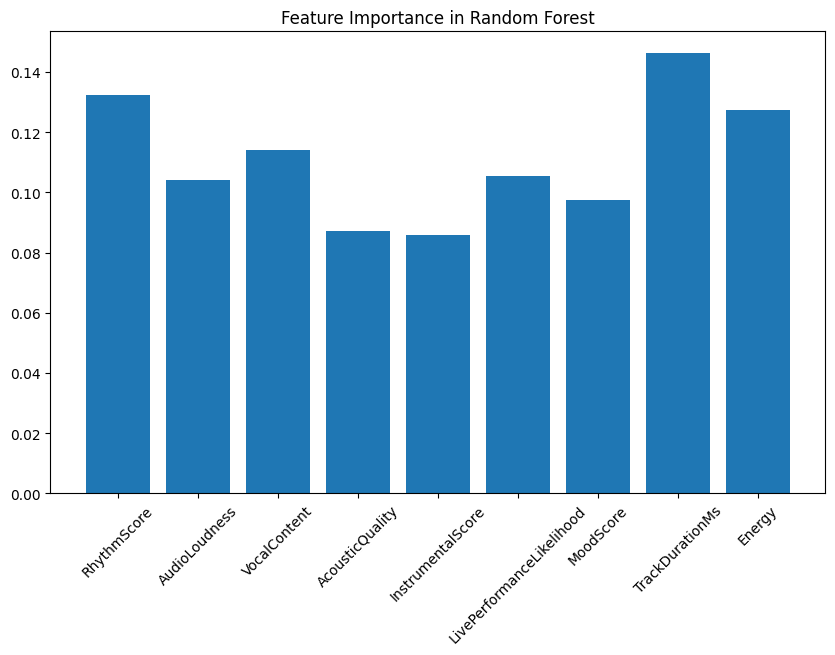

In [10]:
importances = best_rf.feature_importances_
feature_names = features
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)
plt.show()

# Drop two lowest importance features (e.g., if <0.05, adjust based on plot)

In [11]:
drop_features = [feature_names[i] for i in np.argsort(importances)[:2]]  
print(f"Dropping least important features: {drop_features}")
for feature in drop_features:
    features.remove(feature)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

Dropping least important features: ['InstrumentalScore', 'AcousticQuality']


# Rescale after feature drop

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Retrain with reduced features

In [13]:
best_rf.fit(X_train_scaled, y_train)
test_pred = best_rf.predict(X_test_scaled)
submission['BeatsPerMinute'] = test_pred
submission.to_csv('submission_rf_tuned_drop.csv', index=False)
print("Submission file created: submission_rf_tuned_drop.csv")

Submission file created: submission_rf_tuned_drop.csv
